# Modeling for Predicting Ratings

In [20]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#a bunch of imports!
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score


# Ignore futurewarnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/PostBooksEDA.csv', index_col=0)
df_encoded = pd.read_csv('../data/PostEncodedBooksEDA.csv', index_col=0)

print(df_encoded.shape)

(978859, 37)


For the initial models we will be building, User ID and ISBN will not be needed since they are merely identifiers and do not have meaningful relationships with the target variable. Additionally, we will work with a sample of the data to minimize computational requirements.

In [3]:
# 1/3 of the data
df_encoded = df_encoded.sample(n=320000, random_state=42)  # random_state for reproducibility

# Sanity check
print(df_encoded.shape)

(320000, 37)


In [4]:
df_encoded = df_encoded.drop(columns=['user_id','isbn'], axis=1)

## Logistic model 

Since logistic models predict values between 0 and 1, we will convert the ratings into implicit (0) and explicit (1) categories to predict whether users are likely to leave a review or not.

To get the best values we are going to use a pipeline and a GridSearch

In [5]:
X = df_encoded.drop('rating', axis=1)
y = df_encoded['rating'].copy()

In [6]:
X.columns

Index(['age', 'year_of_publication', 'Africa', 'Asia', 'Europe',
       'North America', 'Oceania', 'South America', 'author_frequency',
       'author_implicit_encoded', 'author_explicit_encoded',
       'author_avg_all_reviews', 'publisher_frequency',
       'publisher_implicit_encoded', 'publisher_explicit_encoded',
       'publisher_avg_all_reviews', 'de', 'en', 'es', 'fr', 'it', 'unknown_lg',
       'art & culture', 'business & economics', 'children's books',
       'cookbooks', 'fiction', 'health & fitness', 'non-fiction', 'poetry',
       'religion & spirituality', 'science & technology', 'self-help',
       'unknown_category'],
      dtype='object')

In [7]:
y = y.apply(lambda x: 1 if 1 <= x <= 10 else x)

In [8]:
y

29353     1
960339    0
736352    1
383026    0
116871    1
         ..
617001    0
594192    0
800844    0
86325     1
765222    0
Name: rating, Length: 320000, dtype: int64

In [9]:
estimators = [('normalise', StandardScaler()),
              ('reduce_dim', PCA()),
              ('logreg', LogisticRegression())]

pipe = Pipeline(estimators)

params = {'logreg__C': [0.0001, 0.001, 0.1], 
          'logreg__penalty': ['l1', 'l2'],
          'logreg__solver': ['saga', 'liblinear'],
          'reduce_dim__n_components': [25, 27, 29]}

grid_search = GridSearchCV(pipe, params, cv=5)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=10)
    
fitted_search = grid_search.fit(X_train, y_train)

In [11]:
fitted_search.score(X_test, y_test)

0.6838125

In [12]:
# Best hyperparameters
fitted_search.best_params_

{'logreg__C': 0.001,
 'logreg__penalty': 'l2',
 'logreg__solver': 'saga',
 'reduce_dim__n_components': 27}

In [13]:
# Mean test score for each CV fold
fitted_search.cv_results_['mean_test_score']

array([0.67191146, 0.6798125 , 0.68236979, 0.68291146, 0.68277083,
       0.68276562, 0.67135417, 0.67953646, 0.68222396, 0.68268229,
       0.68258854, 0.68258854, 0.67161979, 0.68002604, 0.68235417,
       0.68385417, 0.68294271, 0.68295313, 0.67105729, 0.67995313,
       0.68229688, 0.68339063, 0.68280729, 0.68272917, 0.67144271,
       0.68011979, 0.68213542, 0.68352083, 0.68259896, 0.68246354,
       0.67142187, 0.679875  , 0.682125  , 0.68357292, 0.68258333,
       0.68255208, 0.67149479, 0.67995313, 0.68213542, 0.68352083,
       0.68259896, 0.68252604, 0.67146875, 0.6799375 , 0.68213021,
       0.68347917, 0.68254167, 0.68255729, 0.67141146, 0.67988542,
       0.68213542, 0.68350521, 0.68257292, 0.68251562, 0.67147396,
       0.68006771, 0.682125  , 0.68349479, 0.68256771, 0.68256771,
       0.67146875, 0.67993229, 0.68211979, 0.68351562, 0.68255729,
       0.68250521, 0.67145833, 0.68016146, 0.68211979, 0.68351042,
       0.68255729, 0.68252604, 0.67145833, 0.68011979, 0.68212

In [14]:
fitted_search.score(X_train, y_train)

0.6839739583333333

In [15]:
fitted_search.score(X_test, y_test)

0.6838125

The best Logistic Regression model has...

### Evaluation

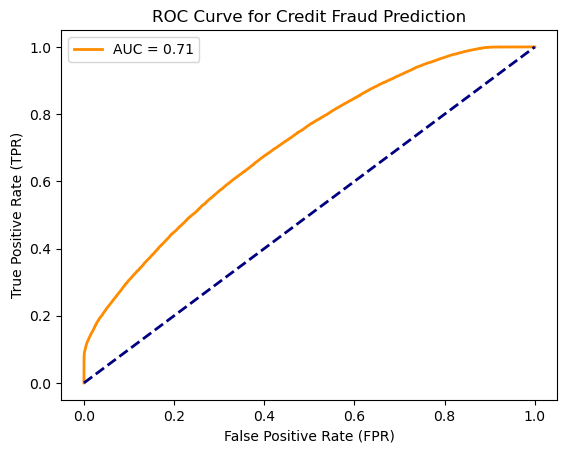

Area under curve (AUC):0.707320233088464



In [21]:
# Regenerate scores
y_proba = fitted_search.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure()
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Credit Fraud Prediction')
plt.legend(loc="best")
plt.show()

print(f'Area under curve (AUC):{roc_auc}')
print()

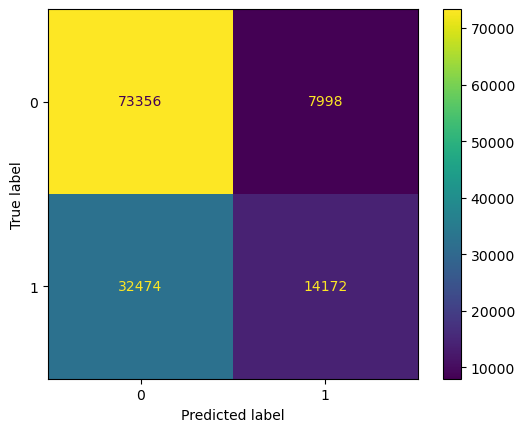

In [29]:
# evaluate on the original test set
y_pred = fitted_search.predict(X_test)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# Get target names
cols = ["0","1"]

# Convert to a DataFrame
cf_df = pd.DataFrame(
    cf_matrix,
    columns=['Predicted ' + x for x in cols],
    index=['True ' + x for x in cols]
)

ConfusionMatrixDisplay(cf_matrix).plot()
plt.show()

In [27]:
print("TEST SET")
print(classification_report(y_test, y_pred))

TEST SET
              precision    recall  f1-score   support

           0       0.69      0.90      0.78     81354
           1       0.64      0.30      0.41     46646

    accuracy                           0.68    128000
   macro avg       0.67      0.60      0.60    128000
weighted avg       0.67      0.68      0.65    128000



## KNeighbors Classifier

This because...

To get the best values we are going to use a pipeline and a GridSearch

In [32]:
# Set X and y
X = df_encoded.drop('rating', axis=1)
y = df_encoded['rating'].copy()

# Transform reviews to 0 and 1
# y = y.apply(lambda x: 1 if 1 <= x <= 10 else x)

# Split the data into train &  test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=10)

# Pipeline with KNN
estimators = [
    ('normalise', StandardScaler()),
    ('reduce_dim', PCA()),
    ('knn', KNeighborsClassifier())
]

pipe = Pipeline(estimators)

# Parameter grid for grid search
params = {
    'knn__n_neighbors': [3, 5, 7, 9, 11],
    'reduce_dim__n_components': [3, 17, 25, 27, 29, 31]
}

# Perform the grid search
grid_searchKn = GridSearchCV(pipe, params, cv=5)

In [ ]:
fitted_searchKn = grid_searchKn.fit(X_train, y_train)

In [ ]:
# Best estimator object
fitted_searchKn.best_estimator_

In [ ]:
# Best hyperparameters
fitted_searchKn.best_params_

In [ ]:
# Mean test score for each CV fold
fitted_searchKn.cv_results_['mean_test_score']

In [ ]:
fitted_searchKn.score(X_train, y_train)

In [ ]:
fitted_searchKn.score(X_test, y_test)

### Evaluation

In [ ]:
# Regenerate scores
y_proba = fitted_searchKn.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure()
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Credit Fraud Prediction')
plt.legend(loc="best")
plt.show()

print(f'Area under curve (AUC):{roc_auc}')
print()

In [ ]:
# evaluate on the original test set
y_pred = fitted_searchKn.predict(X_test)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# Get target names
cols = ["0","1"]

# Convert to a DataFrame
cf_df = pd.DataFrame(
    cf_matrix,
    columns=['Predicted ' + x for x in cols],
    index=['True ' + x for x in cols]
)

ConfusionMatrixDisplay(cf_matrix).plot()
plt.show()

In [ ]:
print("TEST SET")
print(classification_report(y_test, y_pred))

### Insights

this..

## Decision Tree Classifier.

In [ ]:
# Set X and y
X = df_encoded.drop('rating', axis=1)
y = df_encoded['rating'].copy()

# Transform reviews to 0 and 1
# y = y.apply(lambda x: 1 if 1 <= x <= 10 else x)

# Split the data into train &  test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=10)

estimators = [
              ('reduce_dim', PCA()),
              ('model', DecisionTreeClassifier(random_state=20))
             ]

pipe = Pipeline(estimators)

param_grid = { 
              'reduce_dim__n_components': [5, 15, 25],
              'model__max_depth': [4, 8, 12, 16, 20],
              'model__min_samples_leaf': [1, 3, 6, 9],
              'model__min_samples_split': [3, 5, 7, 9] 
             }

gridDTC = GridSearchCV(pipe, param_grid, cv=5)

In [ ]:
fitted_searchDTC = gridDTC.fit(X_train, y_train)

In [ ]:
# Best estimator object
fitted_searchDTC.best_estimator_

In [ ]:
# Best hyperparameters
fitted_searchDTC.best_params_

In [ ]:
# Mean test score for each CV fold
fitted_searchDTC.cv_results_['mean_test_score']

In [ ]:
fitted_searchDTC.score(X_train, y_train)

In [ ]:
fitted_searchDTC.score(X_test, y_test)

### Insights

the ...

### Evaluation

In [ ]:
# Regenerate scores
y_proba = fitted_searchDTC.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure()
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Credit Fraud Prediction')
plt.legend(loc="best")
plt.show()

print(f'Area under curve (AUC):{roc_auc}')
print()

In [ ]:
# evaluate on the original test set
y_pred = fitted_searchDTC.predict(X_test)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# Get target names
cols = ["0","1"]

# Convert to a DataFrame
cf_df = pd.DataFrame(
    cf_matrix,
    columns=['Predicted ' + x for x in cols],
    index=['True ' + x for x in cols]
)

ConfusionMatrixDisplay(cf_matrix).plot()
plt.show()

In [ ]:
print("TEST SET")
print(classification_report(y_test, y_pred))

### Insights

This...

## Summary